# Simple Template for using Logistic Regression with imbalanced Dataset:
- Data exploration and Cleaning
- Creating Piplines for Training and Testing
- Choosing right metrics for model evaluation with imbalanced data
- Simple apporaches for dealing with imbalanced data:
  - Training with weighted model + using f-score for threshold selection
  - Training with resampled dataset(simple-oversampling, Smoth-TomekLinke over and undersampling)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('./Data/data_regression.csv')

In [3]:
df.head()

,year,customer_id,phone_no,gender,age,no_of_days_subscribed,multi_screen,mail_subscribed,weekly_mins_watched,minimum_daily_mins,maximum_daily_mins,weekly_max_night_mins,videos_watched,maximum_days_inactive,customer_support_calls,churn
0,2015,100198,409-8743,Female,36,62,no,no,148.35,12.2,16.81,82,1,4.0,1,0.0
1,2015,100643,340-5930,Female,39,149,no,no,294.45,7.7,33.37,87,3,3.0,2,0.0
2,2015,100756,372-3750,Female,65,126,no,no,87.30,11.9,9.89,91,1,4.0,5,1.0
3,2015,101595,331-4902,Female,24,131,no,yes,321.30,9.5,36.41,102,4,3.0,3,0.0
4,2015,101653,351-8398,Female,40,191,no,no,243.00,10.9,27.54,83,7,3.0,1,0.0


In [4]:
def inspection(dataframe):
  print("Types of the variables we are working with:")
  print(dataframe.dtypes)
  print(50*"-")
  print("Total Samples with missing values:")
  print(df.isnull().any(axis=1).sum())
  print(50*"-")
  print("Total Missing Values per Variable")
  print(df.isnull().sum())
  #print("Map of missing values")
  #sns.heatmap(dataframe.isnull())

In [5]:
inspection(df)

Types of the variables we are working with:
year                        int64
customer_id                 int64
phone_no                   object
gender                     object
age                         int64
no_of_days_subscribed       int64
multi_screen               object
mail_subscribed            object
weekly_mins_watched       float64
minimum_daily_mins        float64
maximum_daily_mins        float64
weekly_max_night_mins       int64
videos_watched              int64
maximum_days_inactive     float64
customer_support_calls      int64
churn                     float64
dtype: object
--------------------------------------------------
Total Samples with missing values:
82
--------------------------------------------------
Total Missing Values per Variable
year                       0
customer_id                0
phone_no                   0
gender                    24
age                        0
no_of_days_subscribed      0
multi_screen               0
mail_subscribed      

In [6]:
# drop the columns without label 
## get the index of rows and drop them 
df_clean=df.drop(df['churn'][df['churn'].isnull()].index)
## drop them and test for null values in churn 
df_clean['churn'][df_clean['churn'].isnull()]
del df
df=df_clean

In [7]:
# numerical and categorical columns
numerical_ix = df.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = df.select_dtypes(include=['object', 'bool']).columns
# number of columns in different categories
print(f'num: {numerical_ix.shape} and cat: {categorical_ix.shape} ')
# explore the unique numbers and range of different columns 
df[categorical_ix].describe().T

num: (12,) and cat: (4,) 


,count,unique,top,freq
phone_no,1965,1965,409-8743,1
gender,1941,2,Male,1032
multi_screen,1965,2,no,1769
mail_subscribed,1965,2,no,1404


- the phone_no columns can be dropped !
- many missing values in gender column
- the value "no" is more pipulated than "yes" in the last 2 columns ! 

In [8]:
df[numerical_ix].describe().T

,count,mean,std,min,25%,50%,75%,max
year,1965.0,2015.000000,0.000000,2015.0,2015.00,2015.00,2015.00,2015.00
customer_id,1965.0,558015.036641,260528.009975,100198.0,331980.00,576100.00,776079.00,999961.00
age,1965.0,38.697710,10.196352,18.0,32.00,37.00,44.00,82.00
no_of_days_subscribed,1965.0,99.750636,39.887889,1.0,72.00,99.00,127.00,243.00
weekly_mins_watched,1965.0,269.894275,80.578226,0.0,218.25,269.55,324.00,526.20
minimum_daily_mins,1965.0,10.198677,2.771632,0.0,8.40,10.20,12.00,20.00
maximum_daily_mins,1965.0,30.588570,9.132183,0.0,24.74,30.55,36.72,59.64
weekly_max_night_mins,1965.0,100.453944,19.545277,42.0,87.00,101.00,114.00,175.00
videos_watched,1965.0,4.490585,2.488576,0.0,3.00,4.00,6.00,19.00
maximum_days_inactive,1939.0,3.249613,0.805421,0.0,3.00,3.00,4.00,6.00


- the year and customer_id columns can be dropped!
- the range between the min and the max values in some columns like  "no_of_days_subscribed",</br>
"weekly_mins_watched" are big, so we try some sorte of standardizations ! 

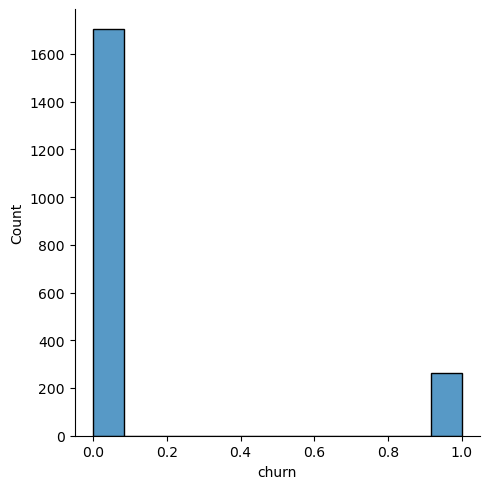

In [9]:
# how is the distribution of label-class (churn)
sns.displot(df.churn);

In [10]:
print(f'there are {df[df.churn==0].churn.count()/df[df.churn==1].churn.count()} more samples from class 0  than class 1 ! ' )

there are 6.5 more samples from class 0  than class 1 ! 


As we can see, we have a significantly imbalanced dataset, so we need to consider taking some actions for training!

In [11]:
# dropping the unnecsseary columns 
df.drop(['year','customer_id','phone_no'],axis=1,inplace=True)
# updating the list of columns 
numerical_ix = list(df.select_dtypes(include=['int64', 'float64']).columns)
categorical_ix = list(df.select_dtypes(include=['object', 'bool']).columns)

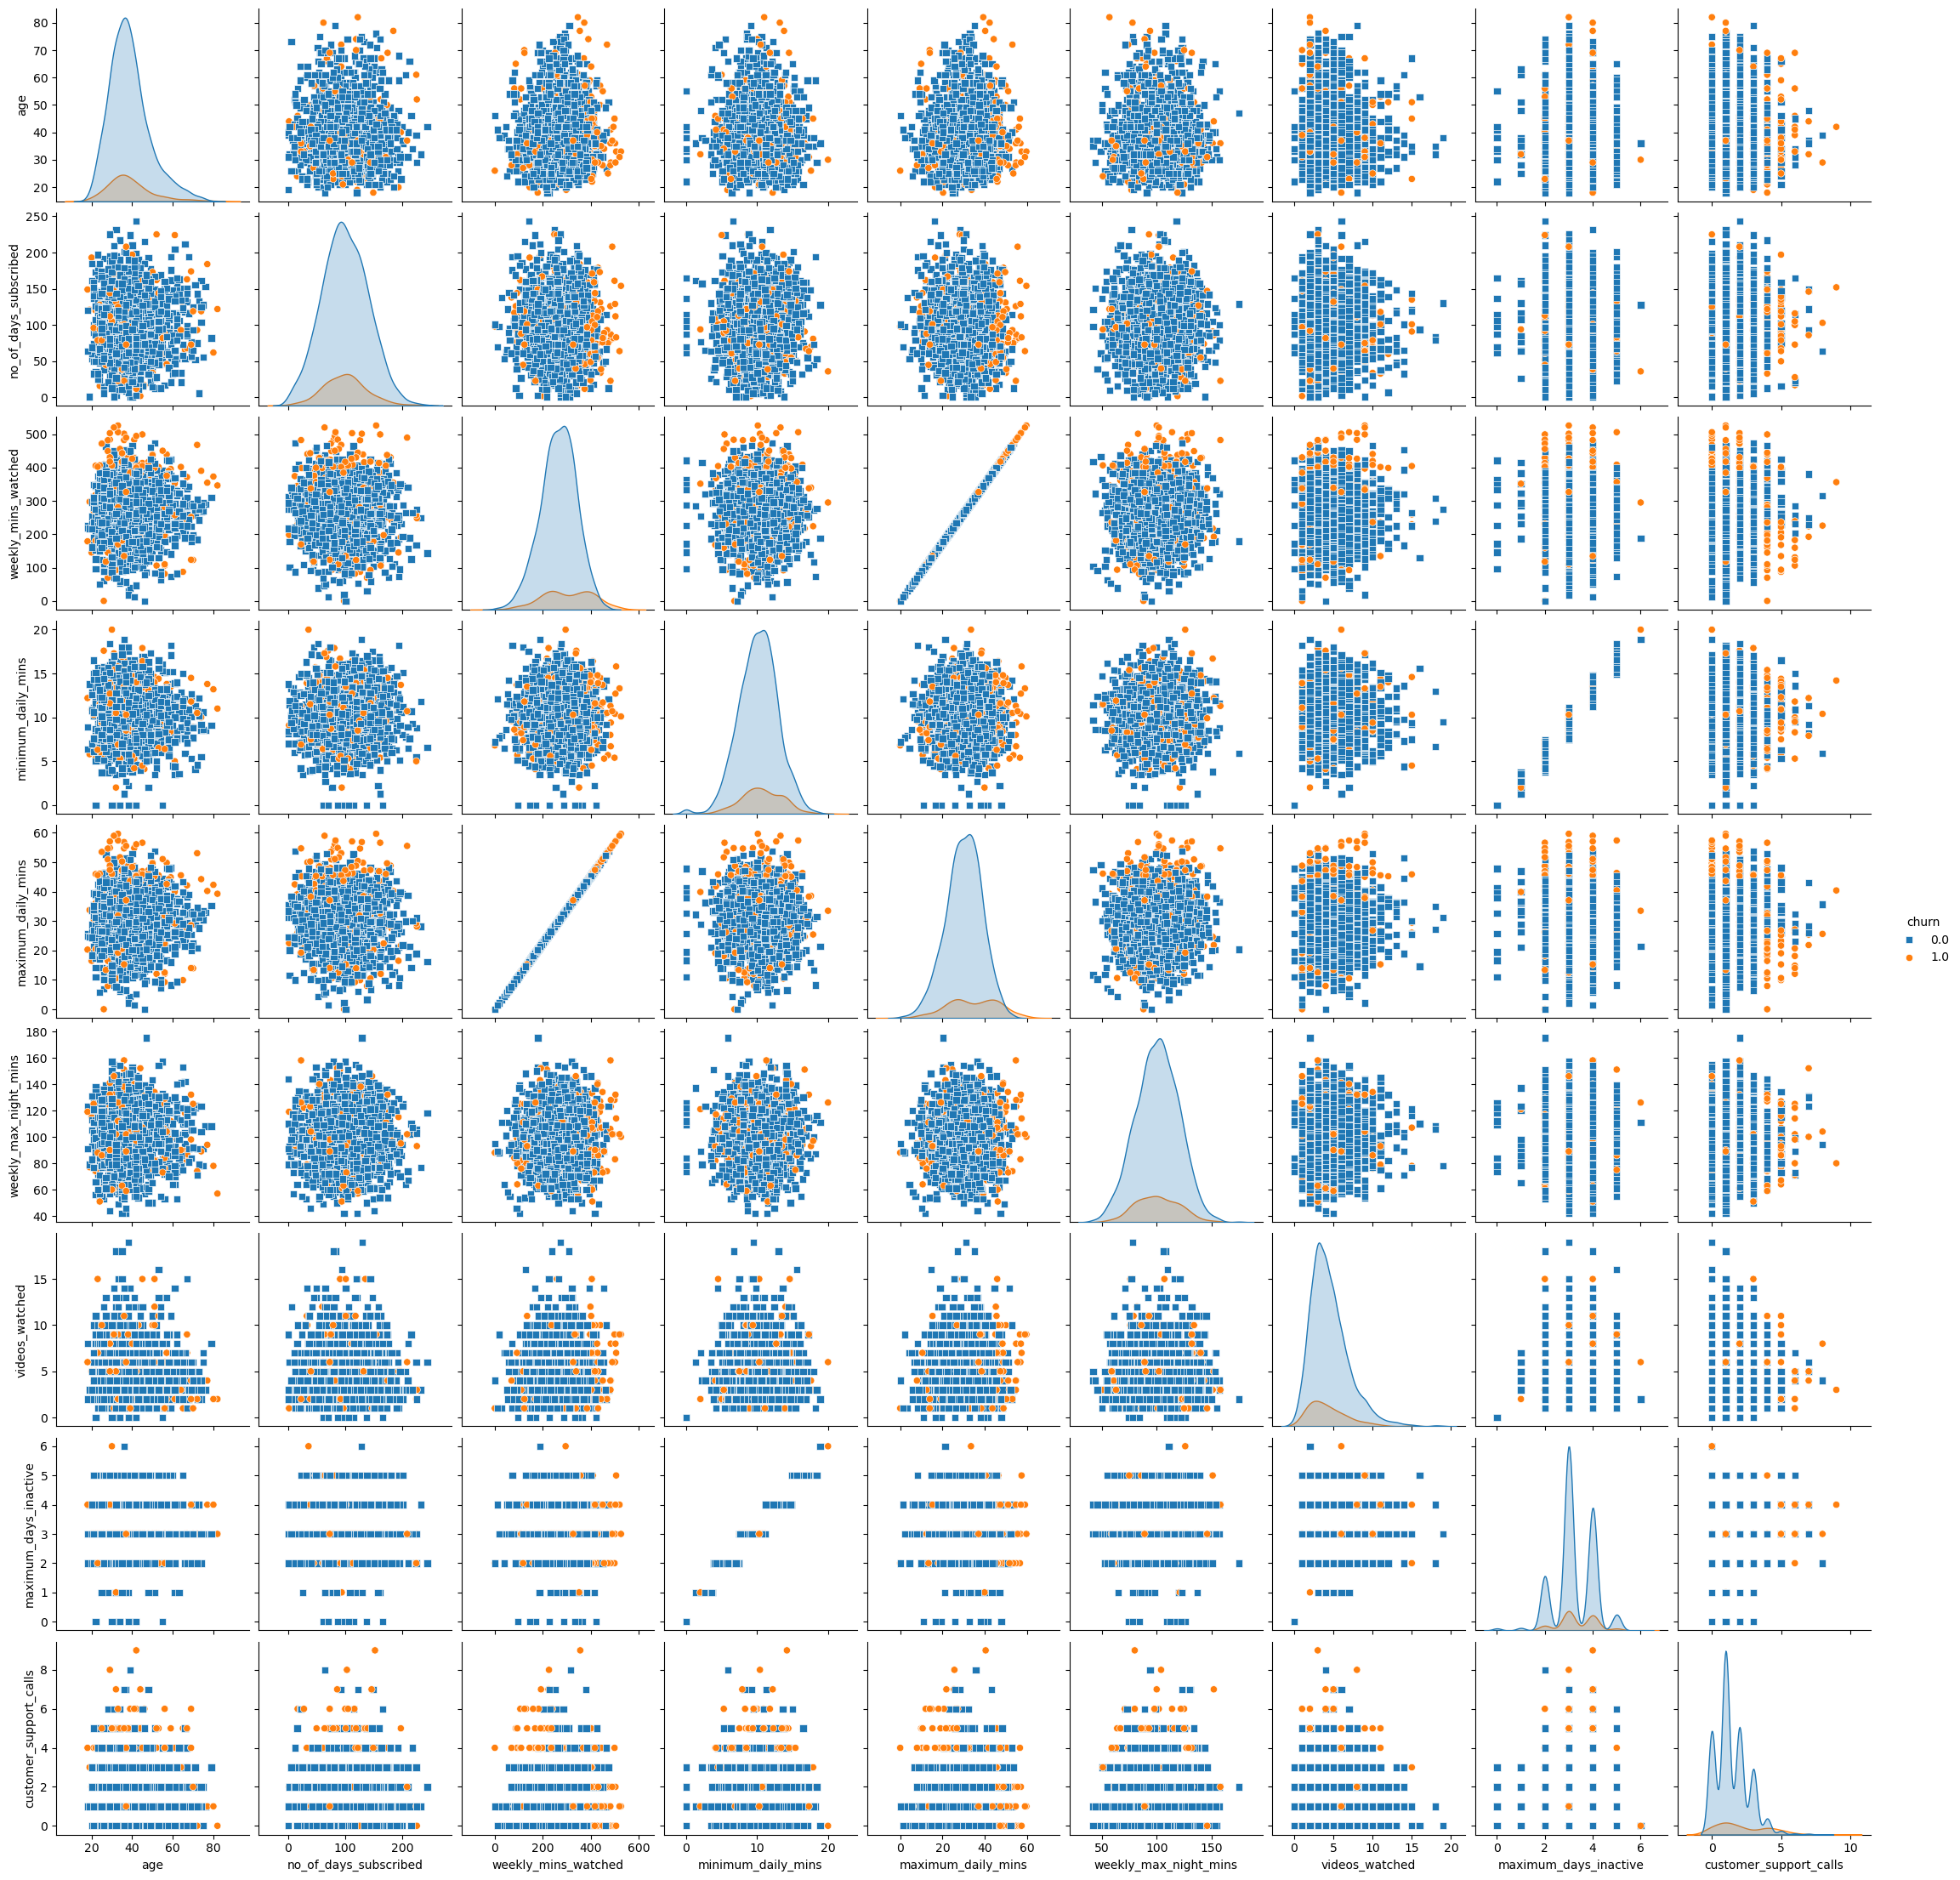

In [12]:
# explore the nummerical columns ! 
# we are looking for see correlation between the columns and clustering based on churn value
sns.pairplot(df[numerical_ix],hue="churn",markers=['s','o'])

- strong linear correlation between weekly_mins_watched and maximum_daily_mins
- customer_support_calls is the obvious one
- because of the big imbalance in the dataset, it's difficult to spot some thing else
__But__ we can see, that linear relations are not strong presented ! 

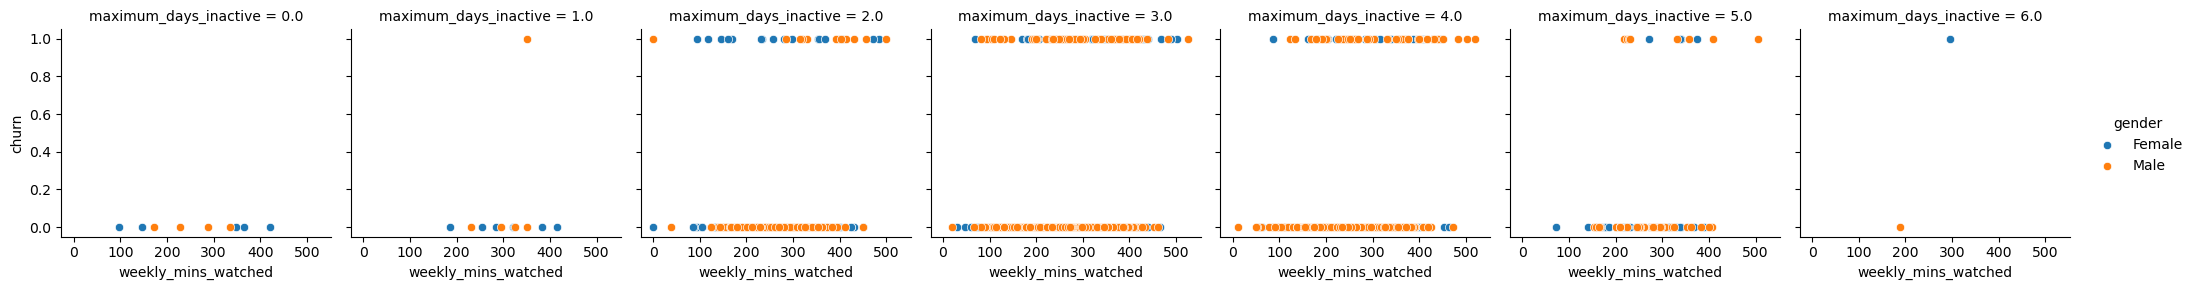

In [13]:
g = sns.FacetGrid(df, col="maximum_days_inactive",hue="gender")
g.map_dataframe(sns.scatterplot, x="weekly_mins_watched", y="churn")
g.add_legend()

5 days inactivity seems to be meaningful for churn

## Creating Piplines for Training and Testing

### Trying different approaches
__I__ am going to test different methodes on the dataset, so I create a function to for basic data preprocessing stepts</br>
so that i can call it and the resulting raw-panadas data frame is the same in every part of the notebook.

In [2]:
def load_dataset_split(ratio=0.75):
    """
    function to split the orginal dataset to a part for training and only testing.
    the test part will be used only for testing (preprocessing , and model)
    ration(float): a number between 0-1 that specify the train part! 
    steps:
        1-read the dataframe
        2-drop rows with nan in the churn column 
        3-drop columns : costumer_id , phone_no, year
        4-spliting the raw data to test and train part by randomly sampling from it.
        the train part will be used to train and test different methodes
        and the test part will only be used for eveluate the final results!
    return:
        train,test: pandas DataFrame 
    """
    #step 1
    df=pd.read_csv('./Data/data_regression.csv')
    #step 2 
    df_clean=df.drop(df['churn'][df['churn'].isnull()].index)
    df_clean['churn'][df_clean['churn'].isnull()]
    del df
    df=df_clean
    #step 3 
    df.drop(['year','customer_id','phone_no'],axis=1,inplace=True)
    #step4
    train_test_r=ratio
    df_train=df.sample(frac=train_test_r,random_state=1324)
    df_test=df.drop(df_train.index)
    print("train: ",df_train.shape)
    print("test: ",df_test.shape)
    return df_train,df_test

In [2]:
def load_dataset():
    """
    function to load the dataset and executes the basic data cleaning steps
    steps:
        1-read the dataframe
        2-drop rows with nan in the churn column 
        3-drop columns : costumer_id , phone_no, year
    return:
        dataset : pandas DataFrame 
    """
    #step 1
    df=pd.read_csv('./Data/data_regression.csv')
    #step 2 
    df_clean=df.drop(df['churn'][df['churn'].isnull()].index)
    df_clean['churn'][df_clean['churn'].isnull()]
    del df
    dataset=df_clean
    #step 3 
    dataset.drop(['year','customer_id','phone_no'],axis=1,inplace=True)
    print("Size of dataset: ",dataset.shape)
    return dataset

In [112]:
dataset=load_dataset()

Size of dataset:  (1965, 13)


In [3]:
# prepricessing
from sklearn.preprocessing import TargetEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# metrics  
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score,classification_report, make_scorer,auc,roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,precision_recall_curve

## Functions for evaluating the model

In [4]:
#-------------------------------------------------------
def plot_confusion_m(test_y,model_preds):
    """
    function to plot standardized confusion matrix in row and column wise
    
    test_y(float): class-labels
    model_preds(float): model predictions
    
    """
    f = plt.figure(figsize=(12,6))
    # confusuin matrix standarditation rows
    ax2 = f.add_subplot(121)
    cm = confusion_matrix(test_y, model_preds,labels=[0,1],normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax2)
    disp.ax_.set_title("standardization in rows")
    # confusuon matrix standardization columns
    ax3 = f.add_subplot(122)
    cm = confusion_matrix(test_y, model_preds,labels=[0,1],normalize='pred')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax3)
    disp.ax_.set_title("standardization in columns")
    plt.show()   

# plot no skill and model precision-recall curves
def plot_pr_curve(test_y, model_probs,model_preds):
    """
    function to plot precision recall curve with results of perfect and dummy models to comparision 
    test_y (float): GroundTrue
    model_probs (float): probs for class 1 
    model_preds(floats): predicted labels 
    """
    f = plt.figure(figsize=(6,5))
    ax = f.add_subplot(111)
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(test_y[test_y==1]) / len(test_y)
    # plot the no skill precision-recall curve
    ax.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot model precision-recall curve
    precision, recall, _ = precision_recall_curve(test_y, model_probs)
    ax.plot(recall, precision, marker='.', label='Logistic')
    # perfect model, predicted = GroundTrue
    precision, recall, _ = precision_recall_curve(test_y, test_y)
    plt.plot(recall, precision, linestyle='-.', label='Perfect')
    # axis labels
    plt.title('Precision-Recall-Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
     # show the legend
    plt.legend()
    plt.show()   
    # confusion matrix
    plot_confusion_m(test_y,model_preds)
    
#----------------------------------------------------    
    # plot no skill and model roc curves
def plot_roc_curve(test_y, naive_probs, model_probs):
    """
    function to plot ROC curve with results of perfect and dummy models to comparision 
    test_y (float): GroundTrue
    naive_probs (float): probs for class 1 from a dummy model
    model_probs(floats): predicted probs form  trained model 
    """
    # plot naive skill roc curve
    fpr, tpr, _ = roc_curve(test_y, naive_probs)
    plt.plot(fpr, tpr, linestyle='--', label='No Skill')
    # plot model roc curve
    fpr, tpr, _ = roc_curve(test_y, model_probs)
    plt.plot(fpr, tpr, marker='.', label='Logistic')
    # perfect model 
    fpr, tpr, _ = roc_curve(test_y, test_y)
    plt.plot(fpr, tpr, marker=',', label='Perfect')
    plt.title('ROC-Curve')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [5]:
# to simplify the process 
def preprocess_validate(df,target):
    """
    function to cross validate the dataset and a logistic regression classifier
    
    df(pandasDF): all data to test and train
    targt(List(str)): targe column

    Return:
    pipline to preprocess the column of raw dataset 
    
    """
    
    features= [col_name for col_name in df.columns if col_name not in target]
    #features
    numerical_ix = df[features].select_dtypes(include=['int64', 'float64']).columns
    categorical_ix = df[features].select_dtypes(include=['object', 'bool']).columns
    # piplines
    numerical_transformer = Pipeline(
        steps=[
            ("imputer", IterativeImputer(max_iter=10)),('scale', StandardScaler())])
    
    categorical_transformer = Pipeline(
        steps=[
            ("encoder",TargetEncoder(target_type='continuous',smooth="auto")),])
    
    # preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_ix),
            ("cat", categorical_transformer, categorical_ix),],
            remainder="passthrough")
    model = Pipeline(steps=[
        ("model",LogisticRegression(random_state=232))])
    
    # train and test 
    clf = Pipeline(steps=[("preprocessor", preprocessor),("classifier",model),])
    
    # the cross validation function will split the dataset to train and test parts
    y_target=df[target].to_numpy().reshape(-1)
    results=cross_validate(clf,X=df[features],y=y_target,cv=5,n_jobs=-1,return_train_score=False,scoring = ['precision','recall','roc_auc'])
    for i in range(len(results)):
        print(f'round {i}- P: {results["test_precision"][i]} , R: {results["test_recall"][i]} , ROC_AUC: {results["test_roc_auc"][i]} ')
    return preprocessor

In [6]:
def to_labels(pos_probs, threshold):
    """
    function to convert model-probs to 0 and 1 labesls
    pos_probs(float): model Probs for class-1 between 0-1 
    threshold(float): if model-probs > threshold , then 1 else 0

    Retun:
        Class 0 or 1 Labels
    """
    return (pos_probs >= threshold).astype('int')

def find_best_threshold(test_labels,prediction_probs,b=1):
    """
    function to find beste threshold best mix of precion and recall  for class-1
    b=0.5 better precsion ,b=1 balance, b=2 better recall
    
    test_labels(float): labels from GroundTrue
    prediction_probs(float): predicted probibilties for class-1
    b(float): beta parameter for f-score function

    Return: 
        best threshold
    """
    from sklearn.metrics import f1_score,fbeta_score
    thresholds = np.arange(0, 1, 0.001)
    scores = [fbeta_score(test_labels, to_labels(prediction_probs, t),beta=b) for t in thresholds]
    # get best threshold
    ix = np.argmax(scores)
    print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
    new_lables=to_labels(prediction_probs,thresholds[ix])
    plot_confusion_m(test_labels,new_lables)
    return thresholds[ix]

In [23]:
# because of fit_resample in Imblearn 
def sampler_func(X,y,sampling_strategy):
    """
    function to sampling the training dataset
    X: features
    y: labels
    sampling_stategy(str): "simple" simple oversampling, "smothTomek" over and undersampling by creating synthetic data samples
    """
    from imblearn.over_sampling import RandomOverSampler # simple random sampling
    from imblearn.under_sampling import TomekLinks# under sampling
    from imblearn.combine import SMOTETomek# over and over sampling
    from collections import Counter # for testing
    
    if sampling_strategy=="simple":
        #print("training with random over sampling")
        #print(f'before: {y.shape}, {Counter(y)}')
        # pipline for sampling
        ros_pipline = Pipeline(steps=[("simple random resampler ",RandomOverSampler(random_state=0))])
        X,y=ros_pipline.fit_resample(X,y)
        print(f'after random simple oversampling: {y.shape} , {Counter(y)}')
    elif sampling_strategy=="smothTomek":
        #print("training with Smoth over sampling and TomekLink under sampling")
        ous_pipline = Pipeline(steps=[("over & undersampling ",SMOTETomek(random_state=0,tomek=TomekLinks(sampling_strategy='majority')))])
        X,y=ous_pipline.fit_resample(X,y)
        print(f'after Smoth over sampling and TomekLink undersampling: {y.shape} , {Counter(y)}')
    else:
        print(" no sampling selected!")
        return X, y
    return X, y

In [8]:
# for debugging purposes
from sklearn.base import TransformerMixin, BaseEstimator
from collections import Counter # for testing

class Debugger(BaseEstimator, TransformerMixin):


    def transform(self, X):
        # Here you just print what you need + return the actual data. You're not transforming anything. 

        print(f'Shape of Pre-processed Data: {X.shape}')
        #print(data.head(2))
        return X

    def fit(self, X, y, **fit_params):
        print(f'y: {Counter(y)}')
        # No need to fit anything, because this is not an actual  transformation. 

        return self


In [9]:
def train_test(df,preprocessor_pipl,target,weights=None,find_threshold=False,betha=1,sampling_strategy=None):
    """
    function to train ,test and create eveluation metrics for a logistic regression model
    
    df: pandas DataFrame
    preprocessor_pipl: sklearn pipline object
    target(list(str)): column-name with labels
    
    weights(Dict(float)): weights for logistic regression model
    find_threshold(bool): find best threshold for class-1 , based on f-score value
    betha(float): to claculate f-betha score and should be from (0.5,1,2) 
    sampling_stategy(str): "simple" simple random samping , "smothTomek" smoth(oversampling) and TomekLink(unde) 

    Return:
        test_pipline: pipline to preprocess the new dataset and test the model ! 
        (only use model.predict(pandas_testdataset) for testing!)
    """
    from sklearn.dummy import DummyClassifier # dummy model for comparison tge plot results
    from imblearn import FunctionSampler # issue with fit_transfrom(sklearn) and fit_resample(imblearn) 

    #preprocessing pipline
    
    features= [col_name for col_name in df.columns if col_name not in target]
    
    X=df[features]
    y=df[target].to_numpy().reshape(-1)
    #-----------------------------------------
    # train and test 
    test_r=0.2
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=test_r, random_state=0, stratify=y)
    #print("------  ",type(trainX))
    #------------------- no skill model------------------
    ## another final part of pipline for dummy model 
    model_dummy = Pipeline(steps=[("dummy_model",DummyClassifier(strategy='stratified'))])
    #model_dummy = Pipeline(steps=[("smoth-sampling",DummyClassifier(strategy='stratified'))])

    #-------------------Logisitc Regression----------------------------------
    if weights is None:
        weights={0:1,1:1}
    
    model = Pipeline(steps=[("model",LogisticRegression(random_state=232,class_weight=weights))])
    #clf = Pipeline(steps=[("preprocessor", preprocessor_pipl),("classifier",model),])
    
    #---------------------------------Simple Sampling-----------------------
    if sampling_strategy is not None:
        debugger=Debugger()
        sampler=FunctionSampler(func=sampler_func,kw_args={"sampling_strategy": sampling_strategy})
        clf_dummy = Pipeline(steps=[("preprocess", preprocessor_pipl),\
                                    ("sampling", sampler),\
                                   # ("debugger",debugger),\
                                    ("dummy_classifier",model_dummy),])
        #-------------------------------------
        clf = Pipeline(steps=[("preprocess", preprocessor_pipl),\
                              ("sampling",sampler),\
                              ("lr_classifier",model),])
    else:
        clf_dummy = Pipeline(steps=[("preprocessor", preprocessor_pipl),("dummy_classifier",model_dummy),])
        clf = Pipeline(steps=[("preprocessor", preprocessor_pipl),("classifier",model),])

    #-----------------------------------------------------------------
    
    clf_dummy.fit(trainX, trainy)
    #print("after fitting: " ,trainX.shape,"  ", trainy.shape)
    yhat = clf_dummy.predict_proba(testX)
    naive_probs = yhat[:, 1]
    # calculate roc auc
    roc_auc = roc_auc_score(testy, naive_probs)
    print('No Skill ROC AUC %.3f' %roc_auc)
    #-------------------Skilled Model ------------------
    clf.fit(trainX, trainy)
    yhat = clf.predict_proba(testX)
    model_probs = yhat[:, 1]
    # calculate roc auc
    roc_auc = roc_auc_score(testy, model_probs)
    print('Logistic ROC AUC %.3f' %roc_auc)
    # plot roc curves
    plot_roc_curve(testy, naive_probs, model_probs)
    ## Precision Recall AUC
    precision, recall, _ = precision_recall_curve(testy, model_probs)
    auc_score = auc(recall, precision)
    print('Logistic PR AUC: %.3f' % auc_score)
    # plot precision-recall curves
    plot_pr_curve(testy, model_probs,clf.predict(testX))
    # finde best threshold for the trained model ! 
    if find_threshold:
        print("#------------Threshold Selection---------------#")
        model_threshold=find_best_threshold(testy,model_probs,b=betha)
    return clf

## Train a model with imbalanced dataset ! 

In [10]:
# load the dataset and explore the classes  
dataset=load_dataset()
class_0_count=dataset[dataset.churn==0].churn.count()
class_1_count=dataset[dataset.churn==1].churn.count()
print(f'size of dataset: {len(dataset)}, nr of class-0 samples: {class_0_count} , nr of class-1 samples: {class_1_count}')

Size of dataset:  (1965, 13)
size of dataset: 1965, nr of class-0 samples: 1703 , nr of class-1 samples: 262


In [11]:
target=['churn']
preprocess_pipline=preprocess_validate(dataset,target)

round 0- P: 0.46153846153846156 , R: 0.11538461538461539 , ROC_AUC: 0.7568238213399504 
round 1- P: 0.5555555555555556 , R: 0.09615384615384616 , ROC_AUC: 0.813162643807805 
round 2- P: 0.2 , R: 0.019230769230769232 , ROC_AUC: 0.778817956237311 
round 3- P: 0.375 , R: 0.05660377358490566 , ROC_AUC: 0.8127635960044395 
round 4- P: 0.75 , R: 0.05660377358490566 , ROC_AUC: 0.7173140954495006 


__As__ we see, the results show:
- that the model is good at ROC_AUC-score!(because of the imbalance, the model can predict only class 0 for every input and the score will be high ) </br>
- But it's not good at predicting the the class-1 samples!(low precision and recall (low performance for detecting label-1/chrun))</br>

No Skill ROC AUC 0.503
Logistic ROC AUC 0.742


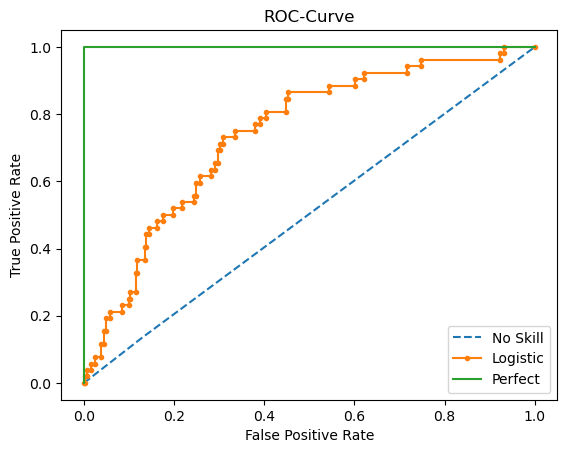

Logistic PR AUC: 0.268


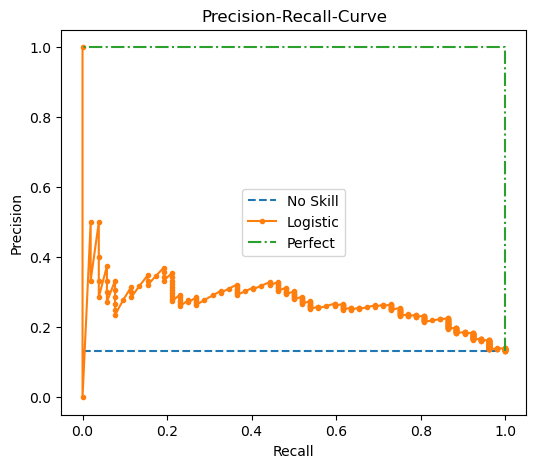

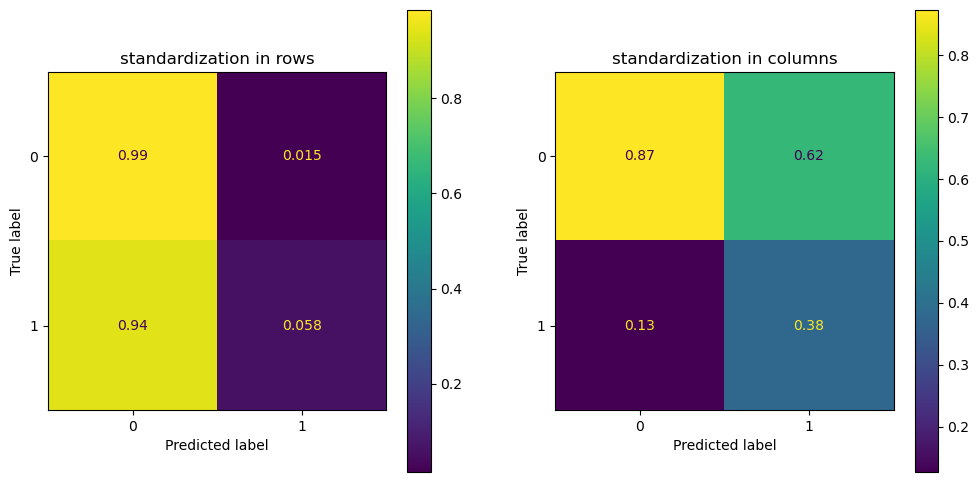

In [12]:
# show train a model and show metrics
test_pipline=train_test(dataset,preprocess_pipline,target)

- __Now__ we observe the effects of severe class imbalance! The model classify almost everything as 0 class!
- for class-1 :
    - The left confusion matrix shows, that only about 5% of class-1 samples are correctly predicted!
    - In the right confusion matrix we see, that 60 % of class-1 predictions are wrong !
    - So from all of class-1 predicions are only 40 % right and this 40 % right predictions are 5% of all class-1 samples!
- for class-0:
  - the model predictions contain 99% of class-0 samples.
  - this 99% of class-0 samples are part of 87% of correct model predictions for class-0!</br>
  - the 13% wrong prediction for class-0 are about 95% of class-1 population, which are wrongly as class-0 predicted! 
- __Even__ if this model can recognize 100% of class-0 samples, because it also almost all of class-1 samples as class-0, it is useless!


## Simple apporaches for dealing with imbalanced data

### some minor change
- step 1 : a way to tackle the problem with class imbalance is using  weights in the  classifier
- step 2: anoother way is to use a threshold based on F-Score-function with weights on reducing FPR(False Positive Rate)

No Skill ROC AUC 0.494
Logistic ROC AUC 0.751


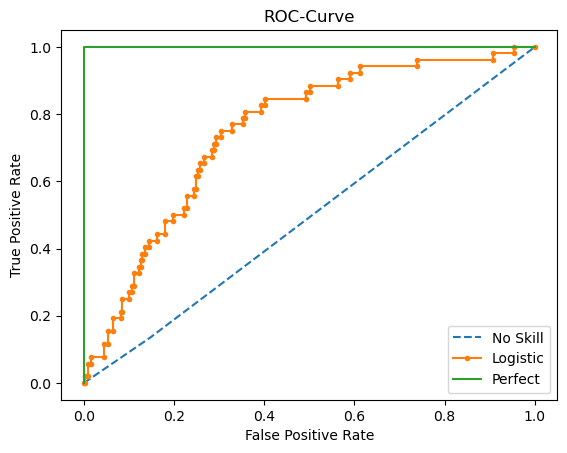

Logistic PR AUC: 0.268


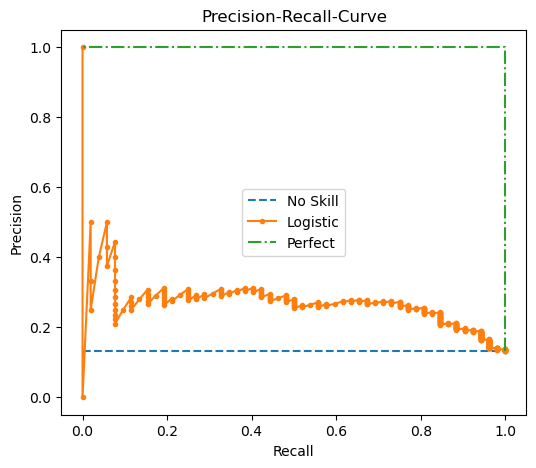

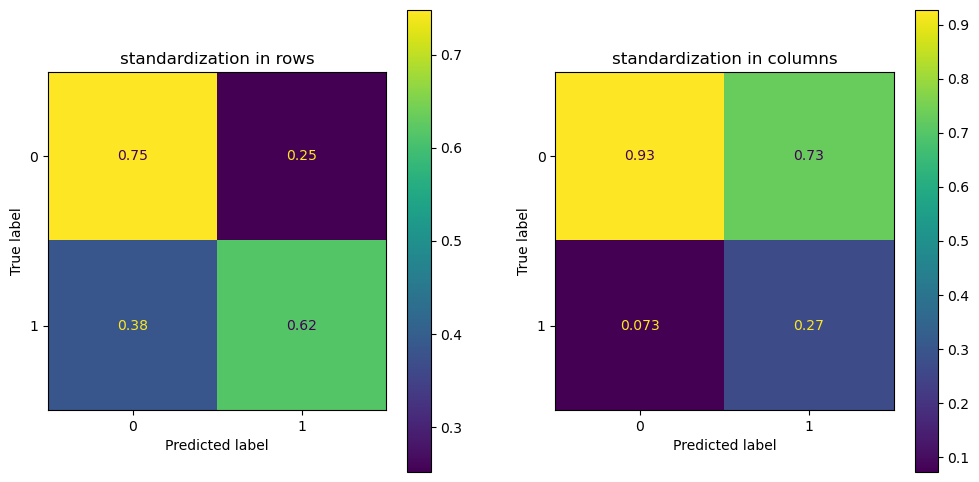

In [16]:

# step 1
# we saw on the hist plot , that population of class 0 is almost 6 times greather than class 1 
w={0:1,1:7}
test_pipline=train_test(dataset,preprocess_pipline,target,weights=w)

__As__ wee see, the ROC and Precision-Recall Curves are almost the same as before but: 
- now we are better at predicting class-1, because the model predictions contain about 60% of class-1 samples, but the cost of it is:
    - from all of class-1 predictions are only 27% right and 73% false(class-1 prediction are not useful)
    - on the other side , the model can capture only 75% of class-0 samples and only 7 % of class-0 predictions are false, __BUT__ this  7% are about 40% of class-1 population!
    - even if the model perfomes good at class-0 , but losing 40% of class-1 is still too high ! 

## Alternative way to go:
- as we see, we get bad results for predicting class-1 samples, so:
    - We can increase the recall of model to recognize more percentage of class-1 population. We will then have a bigger FP-Rate(many class-1 prediction = many class-1 flase prediction )!</br>
    - If the FN-Rate(false predicted as class-0) of the model is low enuogh to accept, we can create a new dataset with class-1 prediction of the model</br>
      and will drop as class-0 classified samples from orginal dataset and train another model as second step , in this way we predict class-1 and class-0 </br>
      with a more balanced datast! 


### Step 2 : - looking for a good threshold by maximaxing the f-beta score and creating new lables 
- __using__ fbeta to put more weight on precision or recall:
    - betha = 0.5 : better precision in class-1 means less wrong classified class-0 as 1, less prediction of class-1 , less wrong predictions of class-1 , but more
        false prediction for class-0
    - betha = 2 : better recall than precision, means more predictions for class-1 , more wrong prediction for class-1 __BUT__ less wrong prediction for </br>
    class 0 and better precision for class-0
- With betha =2 is the model at least good enugh to predicting class-0 and because  most of data-samples are from class-0</br>
we can do some data preprocessing with the model and sort out the obvious class-0 cases and train another model with the part of dataset </br>
population, which is predicted as class-1 by the model! 


No Skill ROC AUC 0.500
Logistic ROC AUC 0.750


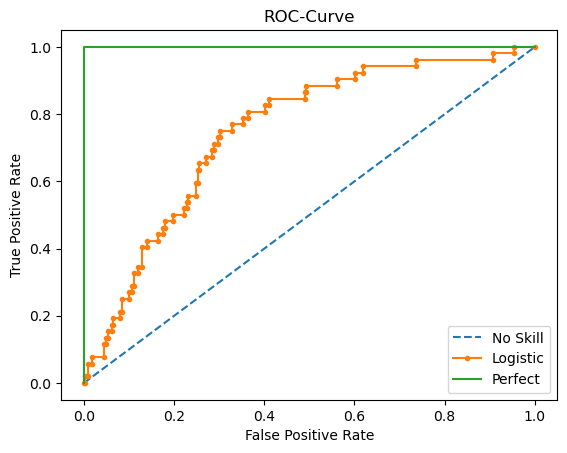

Logistic PR AUC: 0.267


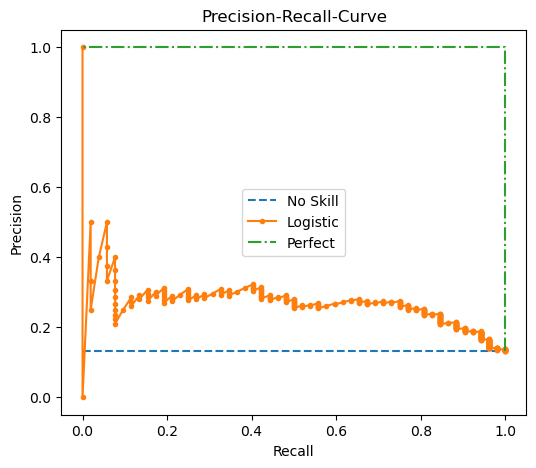

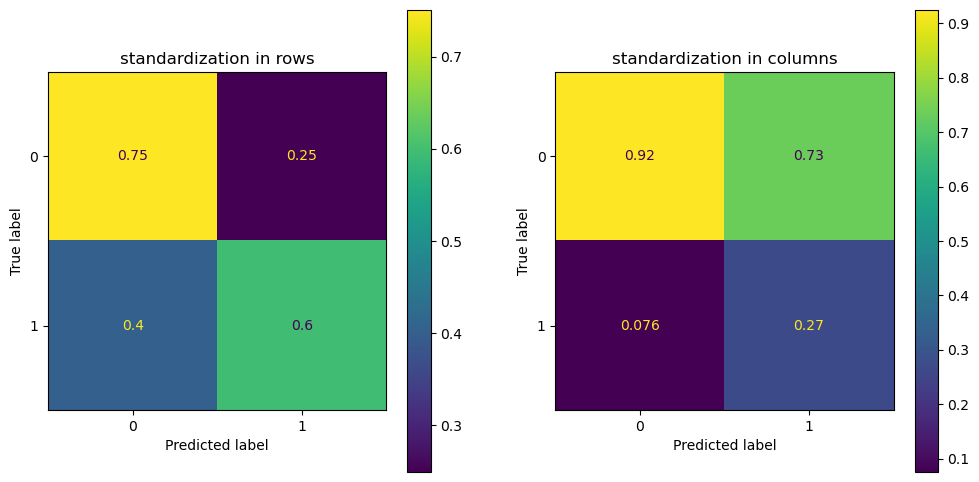

#------------Threshold Selection---------------#
Threshold=0.404, F-Score=0.56150


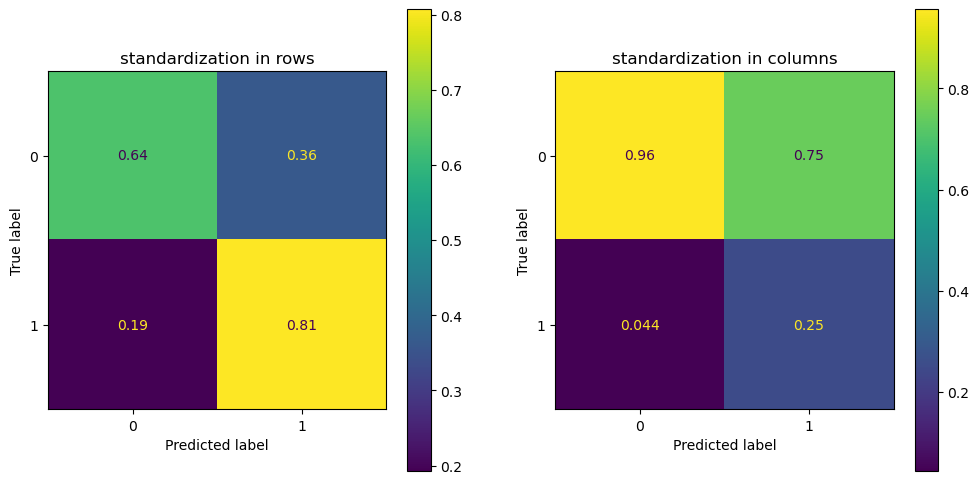

In [20]:
w={0:1,1:7}
test_pipline=train_test(dataset,preprocess_pipline,target,weights=w,find_threshold=True,betha=2)

### point to note:
As we see, with weighted model and looking for a threshold for better recall(f-betha), we have more class-1 samples, that are regcognized!</br>
- even if only 5% of class-0 predictions are wrong , this percentage is about 20% of class-1 populations !
- class-1 population is already the minority class and it might not be a good idea to drop 20% of it's samples! 
- we will look for other apporaches to deal with imblance!

## Resampling (Oversampling)
In This part , we will use 2 oversampling technics to create a balanced dataset , train and validate the models and test them:
- Step 1: create a balanced dataset with simple resampling (sklearn) and train and test a new model
- Step 2 : create a balanced new datast with Synthtic samples() by using over and under sampling technics(imblearn) 

In [21]:
# load the dataset and explore the classes  
#df_train,df_test=load_dataset(ratio=0.8)
class_0_count=dataset[dataset.churn==0].churn.count()
class_1_count=dataset[dataset.churn==1].churn.count()
print(f'size of dataset: {len(dataset)}, nr of class-0 samples: {class_0_count} , nr of class-1 samples: {class_1_count}')

size of dataset: 1965, nr of class-0 samples: 1703 , nr of class-1 samples: 262


after random simple oversampling: (2724,) , Counter({0.0: 1362, 1.0: 1362})
No Skill ROC AUC 0.473
after random simple oversampling: (2724,) , Counter({0.0: 1362, 1.0: 1362})
Logistic ROC AUC 0.749


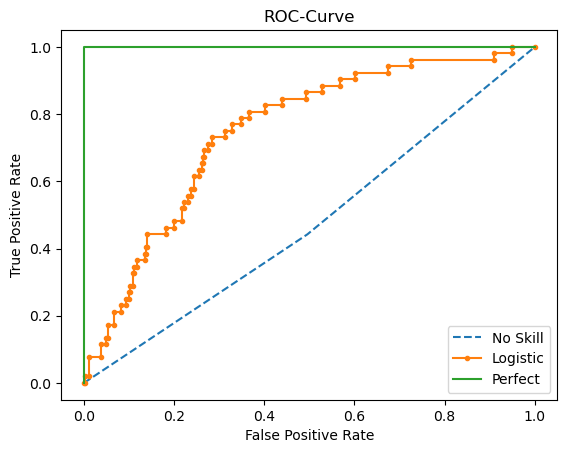

Logistic PR AUC: 0.269


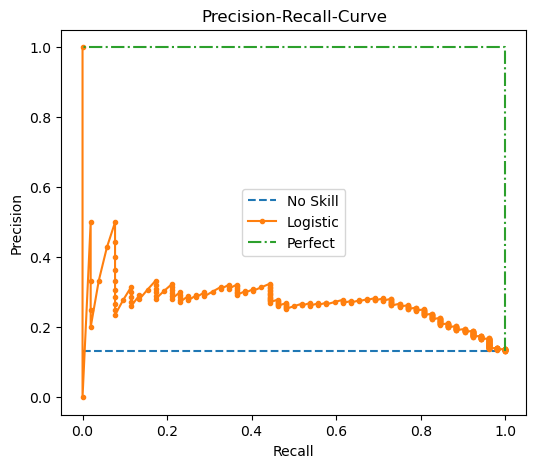

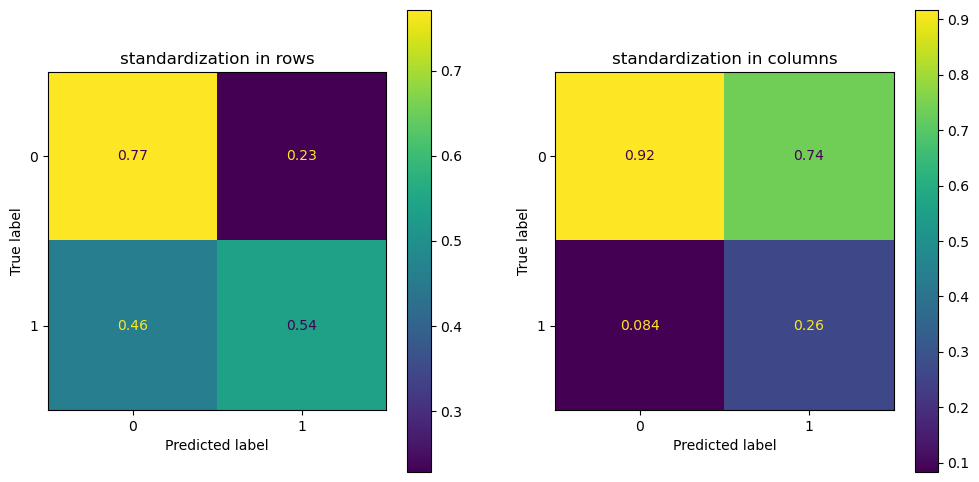

In [24]:
# preprocessing + model testing + simple random sampling
target=['churn']
test_pipline=train_test(dataset,preprocess_pipline,target,sampling_strategy="simple")

- We have better results comparing to the results of model without weights and threshold! </br>

after random simple oversampling: (2724,) , Counter({0.0: 1362, 1.0: 1362})
No Skill ROC AUC 0.467
after random simple oversampling: (2724,) , Counter({0.0: 1362, 1.0: 1362})
Logistic ROC AUC 0.751


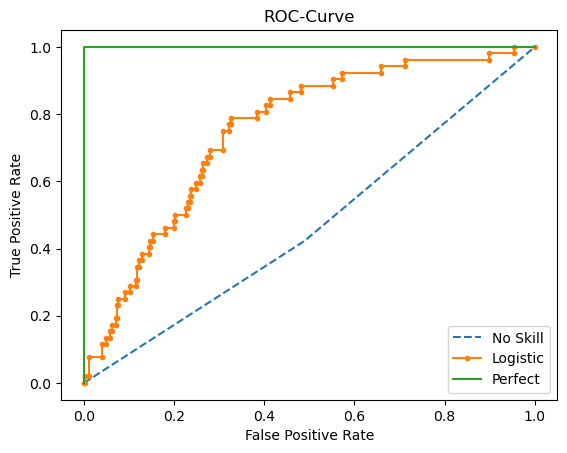

Logistic PR AUC: 0.267


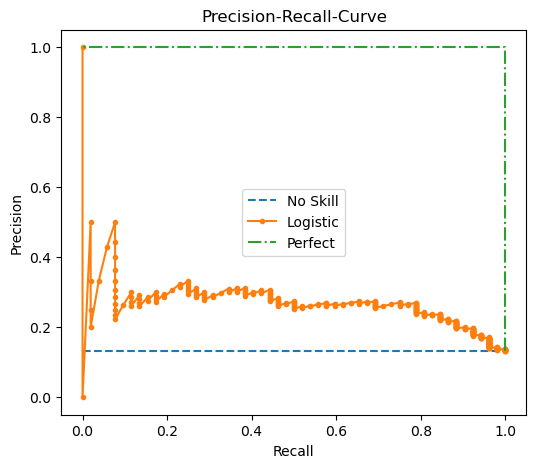

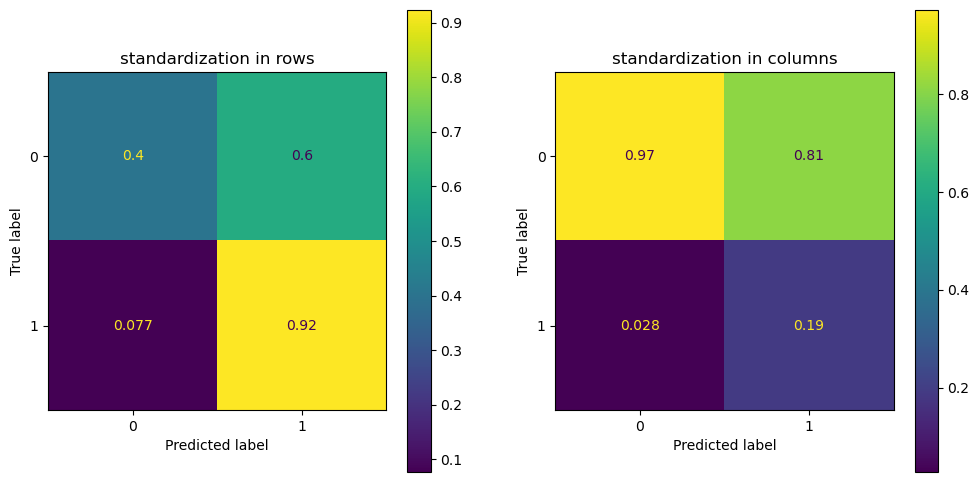

#------------Threshold Selection---------------#
Threshold=0.658, F-Score=0.56944


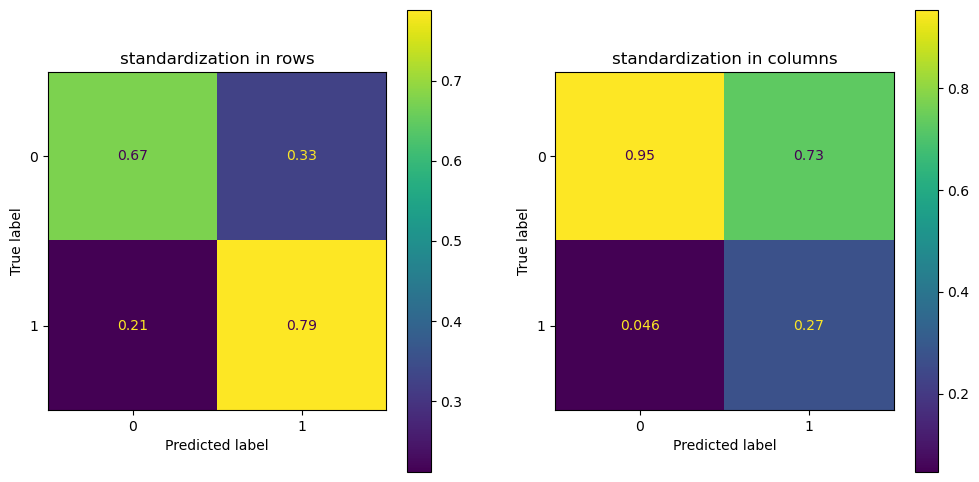

In [47]:
# now sampling,weights and threshold selection 
w={0:1,1:3}
test_pipline=train_test(dataset,preprocess_pipline,target,w,find_threshold=True,betha=2,sampling_strategy="simple")
#test_pipline=train_test(df_train,preprocess_pipline,target,w,find_threshold=True,betha=2)


## To note:
- choosing threshold as standard(0.5) -> good model to filter out class-0 with very good precision and not bad recall (about half of class-0 samples will be dropped for next stage of training!)
- choosing the givin treshold -> class-1 predictions still not good enuogh to keep , becuase of (80% Recall and 21% Precison)

## Over and undersampling

after Smoth over sampling and TomekLink undersampling: (2719,) , Counter({1.0: 1362, 0.0: 1357})
No Skill ROC AUC 0.495
after Smoth over sampling and TomekLink undersampling: (2719,) , Counter({1.0: 1362, 0.0: 1357})
Logistic ROC AUC 0.755


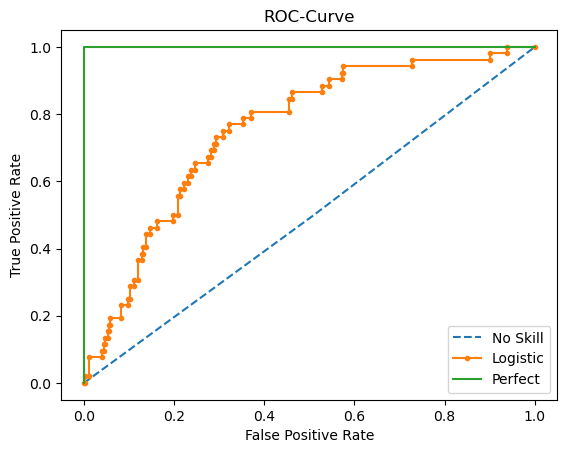

Logistic PR AUC: 0.272


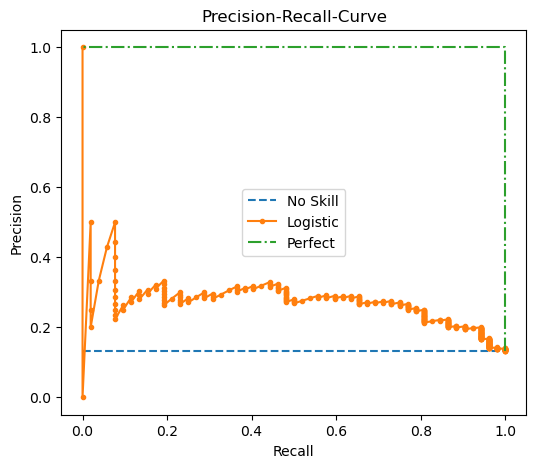

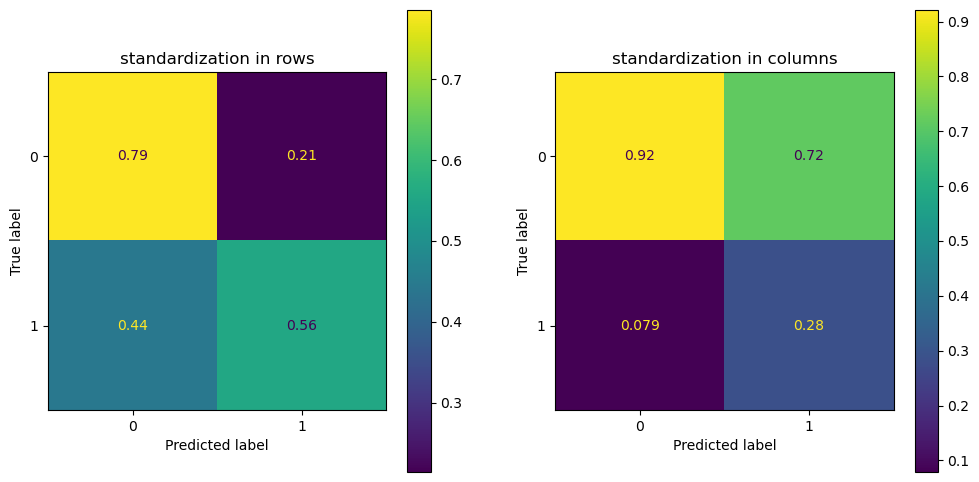

In [48]:
target=['churn']
test_pipline=train_test(dataset,preprocess_pipline,target,sampling_strategy="smothTomek")

- Results look like the results of  the first model with simple oversampling ( without weightes and threshold) 

after Smoth over sampling and TomekLink undersampling: (2719,) , Counter({1.0: 1362, 0.0: 1357})
No Skill ROC AUC 0.443
after Smoth over sampling and TomekLink undersampling: (2720,) , Counter({1.0: 1362, 0.0: 1358})
Logistic ROC AUC 0.756


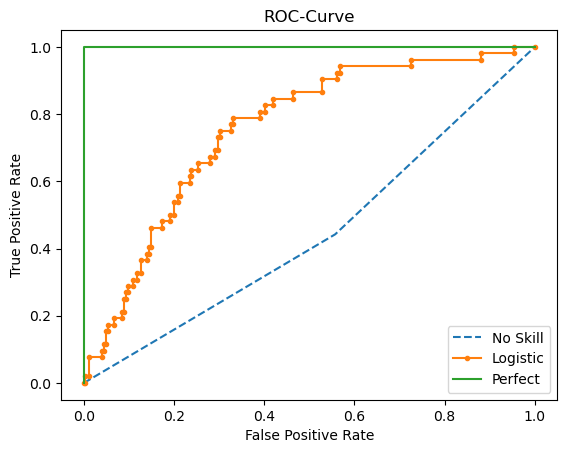

Logistic PR AUC: 0.271


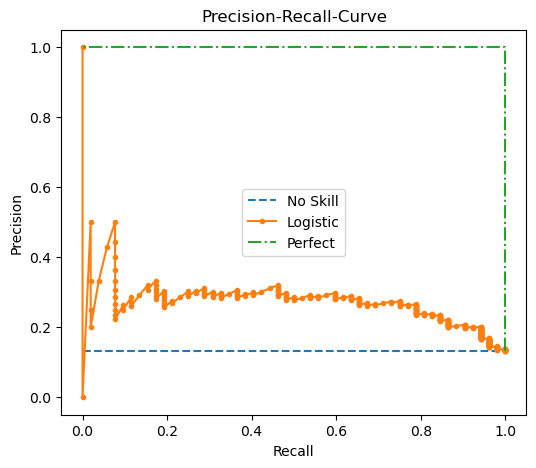

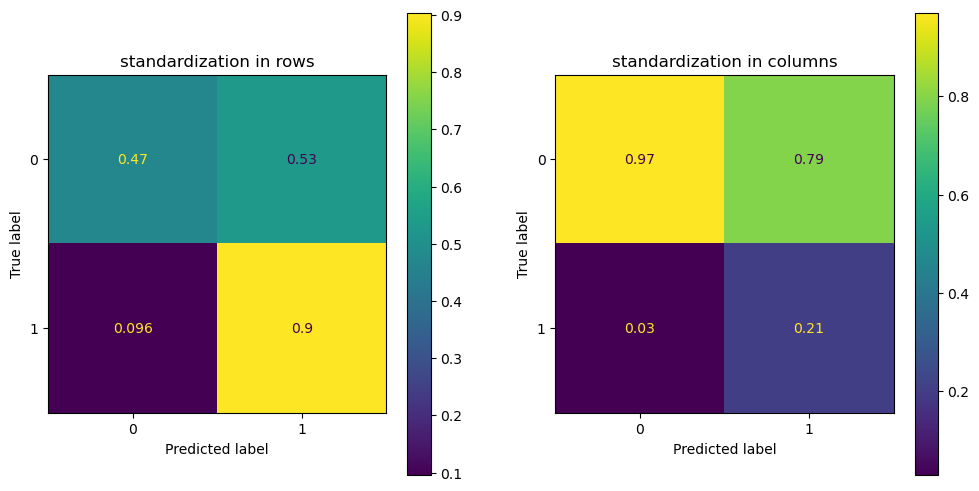

#------------Threshold Selection---------------#
Threshold=0.631, F-Score=0.56630


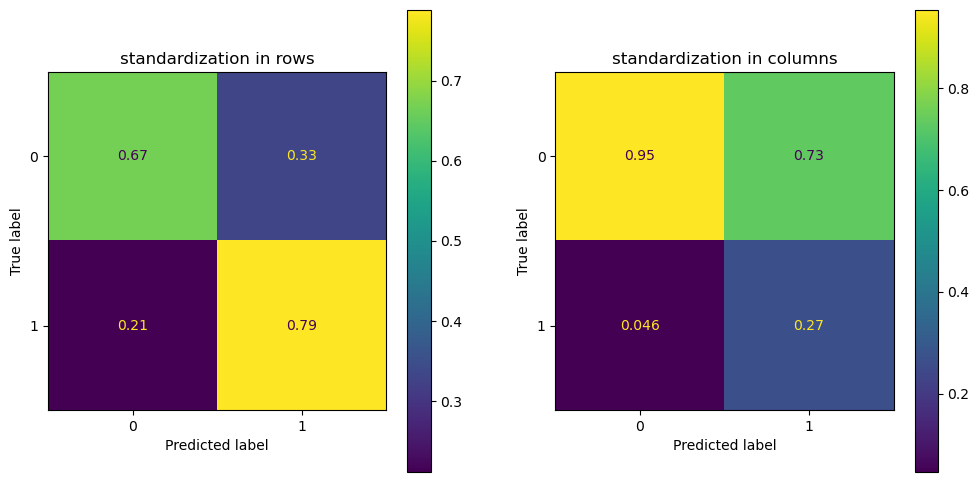

In [51]:
w={0:1,1:3}
test_pipline=train_test(dataset,preprocess_pipline,target,w,find_threshold=True,betha=2,sampling_strategy="smothTomek")

- the weighted model with threshold has same results as simple random oversampling

## We see:
- imbalanced training needs other metrics than accuracy or ROC-AUC
- weigthing and thresholding are good ways to set the focus on Precison and Recall
- Even if resampling is a good idea, it's not a magic wand!
### Logisitc Regression model is not able to solve this classification problem, because the relationships seems to be not linear!!